In [1]:
import warnings
warnings.filterwarnings('ignore')

# Approche classique: embeddings de mots

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("./data/train_df.csv")
train_df = train_df.iloc[:, 1:]
test_df = pd.read_csv("./data/test_df.csv")
test_df = test_df.iloc[:, 1:]

In [4]:
train_df.shape

(3397, 14)

In [5]:
test_df.shape

(1457, 14)

In [6]:
y_train = train_df["target"]
y_test = test_df["target"]

### Embeddings de comptage des mots

En réalisant les embeddings de façon indépendante sur le jeu de train et de test on s'assure qu'il n'y a pas de fuite de données et que l'appréciation de performance du modèle ne sera pas biaisée. Cependant il y a un fort risque d'avoir des OOV lors du test.

In [7]:
train_df .head()#["preprocessed_text"].isna().sum()

,target,ids,date,flag,user,text,sentiment_score,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,length_tokenized,length_preprocessed_tokenized,sia_sentiment
0,1,2177492915,Mon Jun 15 06:12:09 PDT 2009,NO_QUERY,Ayyaya,"@bradhfh well, I hope you don't even if you do...",0,"<mention> well, I hope you do not even if you ...","['<mention>', 'well', ',', 'I', 'hope', 'you',...",<mention> well hope even think sleep airport ...,"['<', 'mention', '>', 'well', 'hope', 'even', ...",27,14,0
1,1,2046797519,Fri Jun 05 12:42:25 PDT 2009,NO_QUERY,ShyHustla,@MamaMisfit Yea but im still grounded for life...,0,<mention> Yea but im still grounded for life a...,"['<mention>', 'Yea', 'but', 'im', 'still', 'gr...",<mention> yea im still grounded life going mak...,"['<', 'mention', '>', 'yea', 'im', 'still', 'g...",20,12,1
2,1,1558166592,Sun Apr 19 07:29:47 PDT 2009,NO_QUERY,shirlise,Driving Alex to the airport Then back to work...,0,Driving Alex to the airport Then back to work ...,"['Driving', 'Alex', 'to', 'the', 'airport', 'T...",driving alex airport back work finish report ...,"['driving', 'alex', 'airport', 'back', 'work',...",31,16,0
3,0,1827398448,Sun May 17 10:37:37 PDT 2009,NO_QUERY,ceibner,big fan of the Morrisey PJ's we got - was so t...,4,Big fan of the Morrisey PJ's we got - was so t...,"['Big', 'fan', 'of', 'the', 'Morrisey', 'PJ', ...",big fan morrisey pj 's got - tempted stay & sn...,"['big', 'fan', 'morrisey', 'pj', ""'s"", 'got', ...",33,15,0
4,1,1553668748,Sat Apr 18 14:53:30 PDT 2009,NO_QUERY,firemanlv,PLEASE tell me they can put me on another earl...,0,PLEASE tell me they can put me on another earl...,"['PLEASE', 'tell', 'me', 'they', 'can', 'put',...",please tell put another earlier flight since m...,"['please', 'tell', 'put', 'another', 'earlier'...",27,14,1


#### CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
train_count_sparse = count_vectorizer.fit_transform(train_df['preprocessed_text'])

test_count_sparse = count_vectorizer.transform(test_df['preprocessed_text'])


In [9]:
# # Précaution à prendre avec les matrices creuses
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
# train_count_scaled = scaler.fit_transform(train_count_sparse)
# test_count_scaled = scaler.fit_transform(test_count_sparse)

In [10]:
import scipy.sparse

# train_count = pd.DataFrame.sparse.from_spmatrix(train_count_sparse, columns=count_vectorizer.get_feature_names_out())

# test_count = pd.DataFrame.sparse.from_spmatrix(test_count_sparse, columns=count_vectorizer.get_feature_names_out())
train_count = pd.DataFrame(train_count_sparse.toarray(), columns=count_vectorizer.get_feature_names_out())
test_count = pd.DataFrame(test_count_sparse.toarray(), columns=count_vectorizer.get_feature_names_out())


In [11]:
from scipy.sparse import csr_matrix, hstack
train_count["target"] = y_train.values
test_count["target"] = y_test.values

### Modélisation des embeddings : test rapides avec Pycaret

In [12]:
# important pycaret supporte python 3.9 à 3.11
import sys
print(sys.version)

3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


In [13]:
# ! pip install pycaret
# ! pip install pycaret[full]

In [14]:
import pycaret

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data=train_count, target='target', test_data=test_count, session_id = 123, index=False, use_gpu=True)

In [16]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [17]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [18]:
# compare baseline models and returns the best 6 ones
best_models = compare_models(sort='Recall',n_select=6 ) #, include=["nb", "lr"]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5013,0.5000,1.0000,0.5013,0.6678,0.0000,0.0000,0.5130
nb,Naive Bayes,0.5558,0.5542,0.7992,0.5389,0.6435,0.1105,0.1256,0.8340
gbc,Gradient Boosting Classifier,0.6759,0.7606,0.7270,0.6606,0.6916,0.3516,0.3543,12.7290
lr,Logistic Regression,0.7115,0.7838,0.6947,0.7201,0.7064,0.4231,0.4241,1.1180
svm,SVM - Linear Kernel,0.6821,0.7521,0.6818,0.6864,0.6823,0.3642,0.3660,1.3100
ridge,Ridge Classifier,0.6906,0.7565,0.6782,0.6975,0.6869,0.3813,0.3823,1.1880
lightgbm,Light Gradient Boosting Machine,0.6862,0.7670,0.6671,0.6951,0.6798,0.3725,0.3737,0.9530
et,Extra Trees Classifier,0.7109,0.7875,0.6507,0.7426,0.6916,0.4221,0.4270,2.1170
rf,Random Forest Classifier,0.6997,0.7862,0.6225,0.7389,0.6743,0.3998,0.4060,1.3480
dt,Decision Tree Classifier,0.6456,0.6515,0.6102,0.6583,0.6325,0.2914,0.2927,1.7380


In [19]:
# Sélection manuelle de modèles pour stacking
nb = best_models[1]  # naives bayes 
lr = best_models[3]  # logistic regression 
gbc = best_models[2]  # Gradient Boosting Classifier

In [20]:
# Construire le modèle Stacked avec ces modèles (on peut aussi créer des modèles lr = create_model("lr"))
stacked_model = stack_models([nb, lr, gbc])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7353,0.8213,0.6901,0.7613,0.7239,0.4709,0.4730
1,0.6941,0.7789,0.6725,0.7055,0.6886,0.3884,0.3888
2,0.6706,0.7696,0.6199,0.6928,0.6543,0.3416,0.3435
3,0.7088,0.8116,0.6941,0.7152,0.7045,0.4176,0.4178
4,0.7176,0.7886,0.7353,0.7102,0.7225,0.4353,0.4356
5,0.7441,0.8180,0.7353,0.7485,0.7418,0.4882,0.4883
6,0.7176,0.7958,0.7412,0.7079,0.7241,0.4353,0.4358
7,0.6785,0.7499,0.6412,0.6943,0.6667,0.3571,0.3581
8,0.7050,0.7759,0.7059,0.7059,0.7059,0.4100,0.4100


In [21]:
stacked_model

StackingClassifier(cv=5,
                   estimators=[('Naive Bayes',
                                GaussianNB(priors=None, var_smoothing=1e-09)),
                               ('Logistic Regression',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=1000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=123,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=Fals...
                                                           validation_fraction=0.1,
                                                           verbose=0,
                                                           warm_start=False))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=123,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=1, passthrough=False, stack_method='auto', verbose=0)

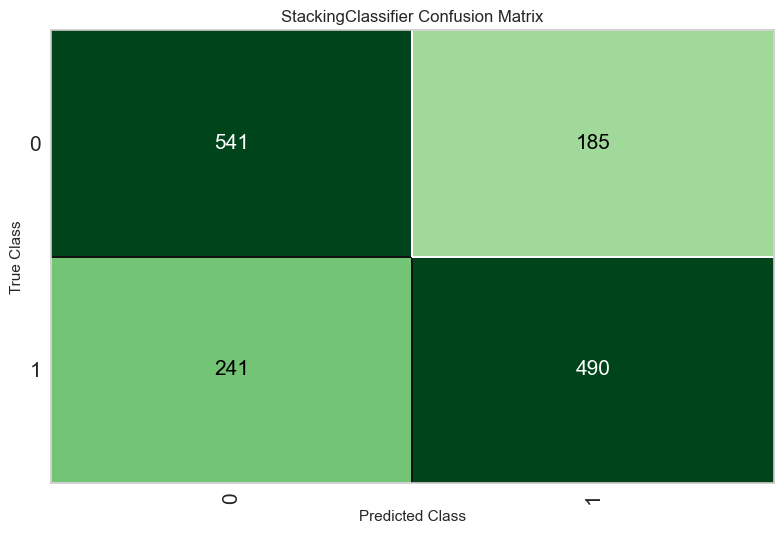

In [22]:
# plot confusion matrix
plot_model(stacked_model, plot = 'confusion_matrix')

Le staking combine les forces des différents modèles en donnant des performances homogènes. Pour cet embedding nous allons aussi optimiser gradient booster qui est le meilleur modèle de qualité (auc, accuracy) acceptable par contre avec un temps de calcul le plus important de tous les classifieurs testés. On optimise par rapport à l'accuracy car l'optimisation selon recall conduit à obtenir uniquement la classe 1.

In [23]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model = tune_model(estimator=gbc, 
                         optimize="Accuracy", choose_better=True,
                         verbose=False)

In [24]:
tuned_model
# ou plot_model(tuned_model, plot="parameter")

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='log_loss', max_depth=7,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.02, min_samples_leaf=5,
                           min_samples_split=5, min_weight_fraction_leaf=0.0,
                           n_estimators=230, n_iter_no_change=None,
                           random_state=123, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

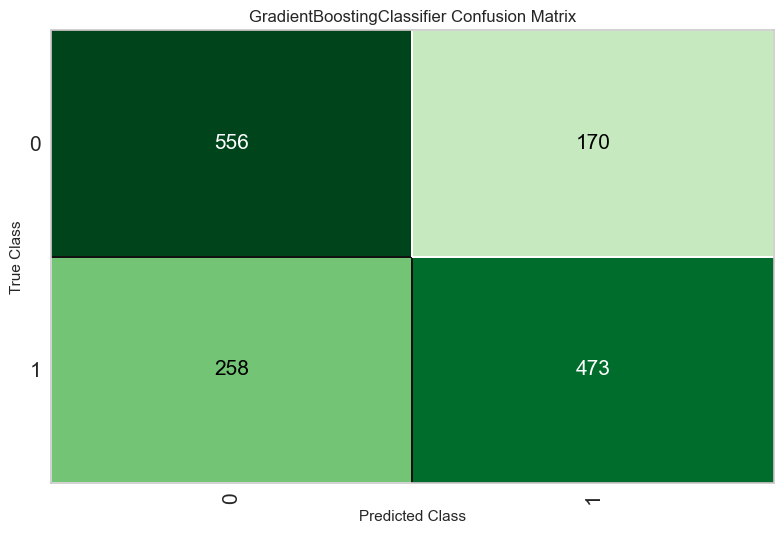

In [25]:
# plot confusion matrix
plot_model(tuned_model, plot = 'confusion_matrix')

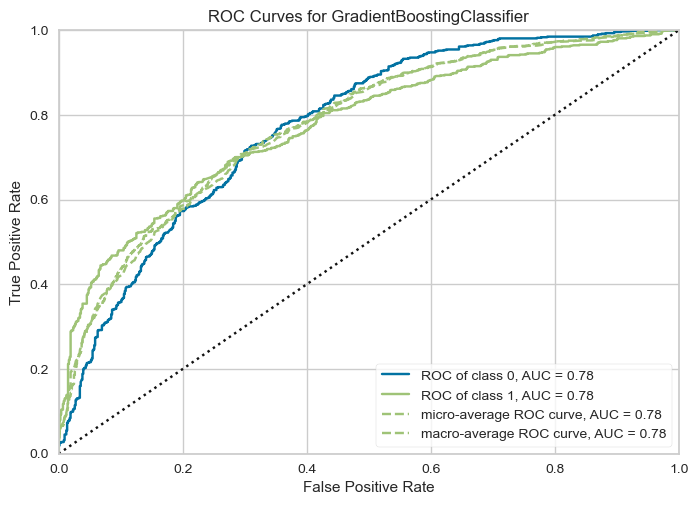

In [26]:
plot_model(tuned_model, plot = 'auc') # Erreur sur les matrices creuses, même en normalisant.

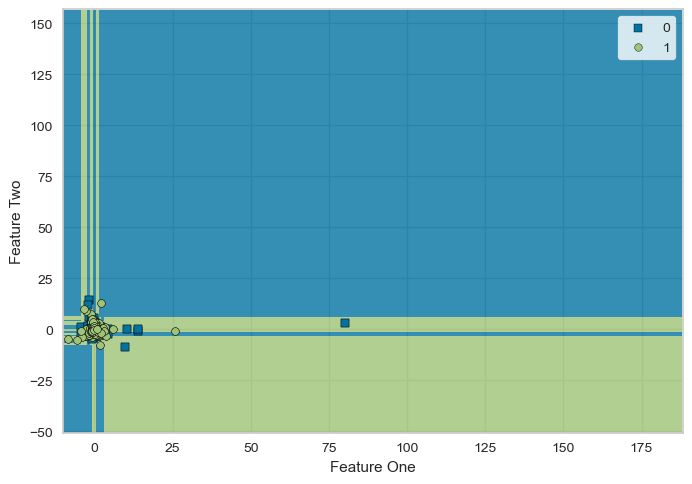

In [30]:
plot_model(tuned_model, plot = 'boundary') # sans normalisation

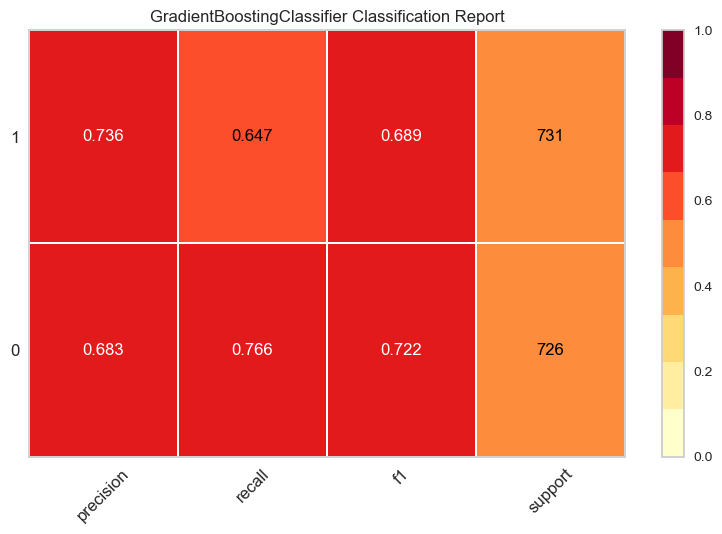

In [27]:
plot_model(tuned_model, plot = 'class_report') # boundary: Erreur sur les matrices creuses, même en normalisant.

In [31]:
pred_holdouts = predict_model(tuned_model)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7062,0.7753,0.6471,0.7356,0.6885,0.4127,0.4158


,0005,0415,0430,0640hr,0830,09,10,100,1000,10000,...,zenny,zero,zexion,zipped,zombie,zone,zulu,target,prediction_label,prediction_score
3397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8607
3398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.6110
3399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.5327
3400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.9633
3401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.7723


In [32]:
pred_holdouts.shape

(1457, 6475)

In [33]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['0005', '0415', '0430', '0640hr',
                                             '0830', '09', '10', '100', '1000',
                                             '10000', '10001s', '10010',
                                             '100bt', '100mph', '1015', '1017',
                                             '1020', '1023', '1039', '1040',
                                             '1045', '105', '1057', '105kg',
                                             '106', '10am', '10hrs', '10k',
                                             '10m', '10mbps', ...],
                                    transformer=SimpleImpute...
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.15, loss='log_loss',
                                            max_depth=7, max_features=1.0,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.02,
                                            min_samples_leaf=5,
                                            min_samples_split=5,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=230,
                                            n_iter_no_change=None,
                                            random_state=123, subsample=0.85,
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False)

In [34]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

# os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(tuned_model, PATH + "models" + os.sep + "best_model_CountVectorizer_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0005', '0415', '0430', '0640hr',
                                              '0830', '09', '10', '100', '1000',
                                              '10000', '10001s', '10010',
                                              '100bt', '100mph', '1015', '1017',
                                              '1020', '1023', '1039', '1040',
                                              '1045', '105', '1057', '105kg',
                                              '106', '10am', '10hrs', '10k',
                                              '10m', '10mbps', ...],
                                     transformer=SimpleImpute...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.15, loss='log_loss',
                       

In [35]:
# Générer des prédictions pour le jeu d'entrainement
predictions = predict_model(tuned_model, data=train_count)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8805,0.9553,0.8620,0.8957,0.8785,0.7610,0.7615


In [54]:
df = predictions

##### Représentation 2D

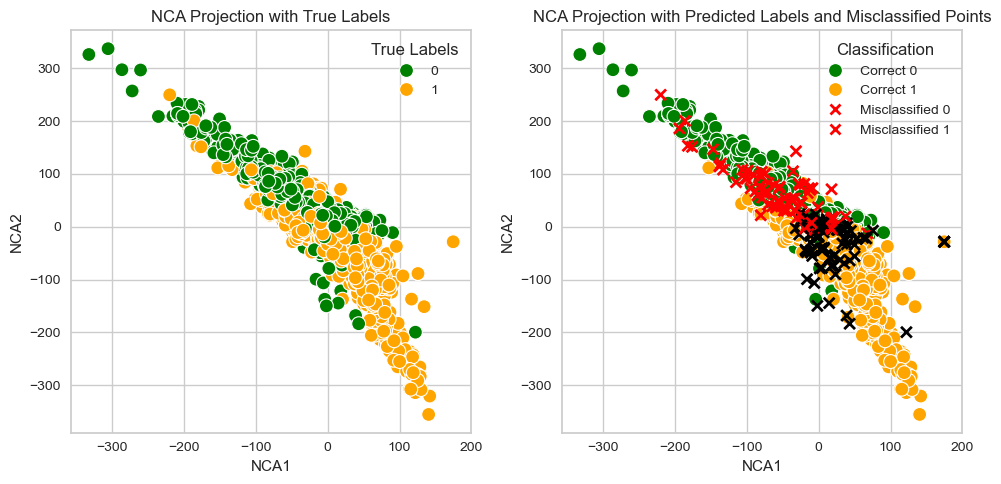


Faux Négatifs (Prédit comme 0, mais vrai label 1) :
- finally friday , but still grounded till next thursday    -- stereos = life &lt;333
- @cathybaron sounds like you caught it during the flight..  Get well soon! lots of honey &amp; lemon drinks!
- Had chilie con carne for dinner,just settled down to watch washington @ Yankees though its pissin in New York so there's a game delay 
- @northwesternsig good grief sig.  you must have a shit load of frequent flyer miles.  have fun! no mike rowe sucks 
- safe travels lady !! hope its not too freezing for you.. like .. seriously  @MissPhoenixxx Hope your flight goes well.. love you a ton Xx
- @RamsackDiego no  I won't but next sunday I will I need the old crew there. http://myloc.me/4Ksz
- @dannygokey Eek! That's too bad  Hope you have better luck with your luggage next time!
- @dannywood good morning danny..have a safe flight(short 1 i hope) &amp; yes im just now goin 2 bed..  @ what 445 gotta b up @ 745 LOVE YOU ~V~
- Going to the airport

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NeighborhoodComponentsAnalysis

def visualize_nca_predictions(df, train_df):
    """
    Visualise les prédictions d'un modèle en utilisant Neighborhood Components Analysis (NCA) en 2D.
    
    Paramètres :
    - df : DataFrame contenant les features, les vraies étiquettes ('target'), et les prédictions ('prediction_label').
    - train_df : DataFrame contenant les textes d'origine pour les faux positifs et faux négatifs.
    """
    
    # Séparer les features des labels
    features = df.drop(columns=['target', 'prediction_label', 'prediction_score'])
    true_labels = df['target']
    predicted_labels = df['prediction_label']

    # Appliquer Neighborhood Component Analysis (NCA) pour réduire à 2 dimensions
    nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
    nca_transformed = nca.fit_transform(features, true_labels)

    # Création d'un DataFrame pour la visualisation
    nca_df = pd.DataFrame(nca_transformed, columns=['NCA1', 'NCA2'])
    nca_df['True Labels'] = true_labels
    nca_df['Predicted Labels'] = predicted_labels

    # Identifier les points mal classés
    nca_df['Misclassified'] = nca_df['True Labels'] != nca_df['Predicted Labels']

    # Identifier les faux positifs et les faux négatifs
    nca_df['False Positive'] = (nca_df['True Labels'] == 0) & (nca_df['Predicted Labels'] == 1)
    nca_df['False Negative'] = (nca_df['True Labels'] == 1) & (nca_df['Predicted Labels'] == 0)

    # Retrouver les textes mal interprétés pour les faux positifs et les faux négatifs
    false_positive_texts = train_df.loc[nca_df[nca_df['False Positive']].index, 'text']
    false_negative_texts = train_df.loc[nca_df[nca_df['False Negative']].index, 'text']

    # Créer une figure avec deux sous-graphes (sans redondance)
    plt.figure(figsize=(10, 5))
    
    # Graphique 1 : Projection NCA avec les labels réels
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='NCA1', y='NCA2', hue='True Labels', data=nca_df, palette={0: 'green', 1: 'orange'}, s=100)
    plt.title('NCA Projection with True Labels')

    # Graphique 2 : Projection NCA avec les labels prédits et les points mal classés
    plt.subplot(1, 2, 2)

    # Points correctement classés (cercles)
    sns.scatterplot(x='NCA1', y='NCA2', hue='Predicted Labels', data=nca_df[~nca_df['Misclassified']], 
                    palette={0: 'green', 1: 'orange'}, s=100, marker='o')

    # Points mal classés (croix "x")
    sns.scatterplot(x='NCA1', y='NCA2', hue='Predicted Labels', data=nca_df[nca_df['Misclassified']], 
                    palette={0: 'red', 1: 'black'}, s=60, marker='x', edgecolor='red', linewidth=2)

    plt.title('NCA Projection with Predicted Labels and Misclassified Points')

    # Ajustement de la légende manuellement
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Correct 0', 'Correct 1', 'Misclassified 0', 'Misclassified 1'], title='Classification', loc='upper right')

    # Afficher les graphes
    plt.tight_layout()
    plt.show()

    # Afficher les textes mal interprétés par groupe
    print("\nFaux Négatifs (Prédit comme 0, mais vrai label 1) :")
    for text in false_negative_texts:
        print(f"- {text}")

    print("\nFaux Positifs (Prédit comme 1, mais vrai label 0) :")
    for text in false_positive_texts:
        print(f"- {text}")

# Exemple d'utilisation
visualize_nca_predictions(df, train_df)


##### Représentation 3D

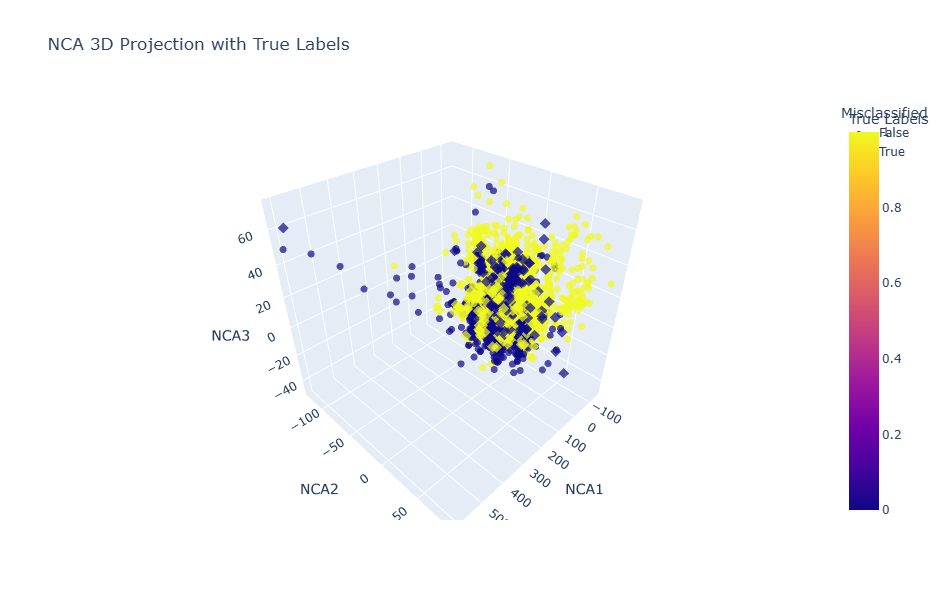

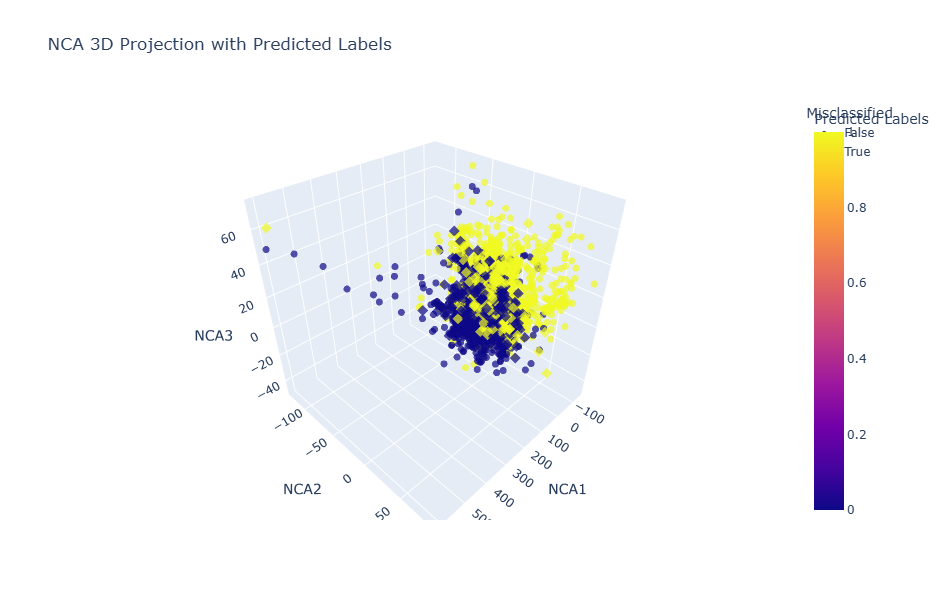


Faux Positifs (Prédit comme 1, mais vrai label 0) :
- patching a DB before an upgrade and then prepping for demo 
- in the plane. Goin' back to perth y'all. Jesus bless da aircraft and da crews. 
- Well I'm on the plane to Atlanta then Vegas!! Almost missed my flight but I'm here now 
- Meh.. Who needs cheap Windows 7 upgrade pricing, when you have friends at Microsoft with an employee discount?  http://is.gd/PDHt
- so how about i hope on the very next flight to Jersey! as long as im there for the FOB signing at 7 
- Total celeb sighting. Blain Howard from Bender's NY office is on our flight. 
- 13 hours til i'm on a plane. Ahhh yay 
- @Sackaveli Sad thing is.... I am close enough to the theatre to WALK. Oh well, I'm watching it online for now  How was your flight?
- Jus left The Mall And Dots  Got My Airplane Outfit For The Plane 
- 'seatbelt inconvenience' - please create a definition of your choosing. 
- In limo from airport... Instead of Town Car they sent a huge Escalade, feeling

In [49]:
import pandas as pd
import plotly.express as px
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# Séparer les features des labels
features = df.drop(columns=['target', 'prediction_label', 'prediction_score'])
true_labels = df['target']
predicted_labels = df['prediction_label']

# Appliquer Neighborhood Component Analysis (NCA) pour réduire à 3 dimensions
nca = NeighborhoodComponentsAnalysis(n_components=3, random_state=42)
nca_transformed = nca.fit_transform(features, true_labels)

# Création d'un DataFrame pour la visualisation
nca_df = pd.DataFrame(nca_transformed, columns=['NCA1', 'NCA2', 'NCA3'])
nca_df['True Labels'] = true_labels
nca_df['Predicted Labels'] = predicted_labels

# Identifier les points mal classés
nca_df['Misclassified'] = nca_df['True Labels'] != nca_df['Predicted Labels']

# Identifier les faux positifs et les faux négatifs
nca_df['False Positive'] = (nca_df['True Labels'] == 0) & (nca_df['Predicted Labels'] == 1)
nca_df['False Negative'] = (nca_df['True Labels'] == 1) & (nca_df['Predicted Labels'] == 0)

# Retrouver les textes mal interprétés pour les faux positifs et les faux négatifs
false_positive_texts = train_df.loc[nca_df[nca_df['False Positive']].index, 'text']
false_negative_texts = train_df.loc[nca_df[nca_df['False Negative']].index, 'text']

# Ajustements de la taille du graphe et des marqueurs
marker_size = 4  # Taille des marqueurs plus petite
figure_size = (800, 600)  # Taille du graphe ajustée

# Graphique 3D interactif avec les labels réels
fig1 = px.scatter_3d(nca_df, x='NCA1', y='NCA2', z='NCA3', color='True Labels',
                     symbol='Misclassified', title='NCA 3D Projection with True Labels',
                     labels={'True Labels': 'True Labels'}, 
                     color_discrete_map={0: 'green', 1: 'orange'}, opacity=0.7)

fig1.update_layout(scene=dict(aspectmode='cube'), width=figure_size[0], height=figure_size[1])
fig1.update_traces(marker=dict(size=marker_size))

# Graphique 3D interactif avec les labels prédits
fig2 = px.scatter_3d(nca_df, x='NCA1', y='NCA2', z='NCA3', color='Predicted Labels',
                     symbol='Misclassified', title='NCA 3D Projection with Predicted Labels',
                     labels={'Predicted Labels': 'Predicted Labels'}, 
                     color_discrete_map={0: 'green', 1: 'orange'}, opacity=0.7)

fig2.update_layout(scene=dict(aspectmode='cube'), width=figure_size[0], height=figure_size[1])
fig2.update_traces(marker=dict(size=marker_size))

# Afficher les graphiques interactifs
fig1.show()
fig2.show()

#### TFIdF

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
train_tfidf_sparse = tfidf.fit_transform(train_df['preprocessed_text'])
test_tfidf_sparse = tfidf.transform(test_df['preprocessed_text'])

In [59]:
import scipy.sparse
train_tfidf = pd.DataFrame(train_tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())
test_tfidf = pd.DataFrame(test_tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())

In [60]:
from scipy.sparse import csr_matrix, hstack
train_tfidf["target"] = y_train.values
test_tfidf["target"] = y_test.values

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s_tf = setup(data=train_tfidf, target='target', test_data=test_tfidf, session_id = 123, index=False, use_gpu=True)

In [62]:
# compare baseline models and returns the best 6 ones
best_models_tf = compare_models(sort='Recall', n_select=6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5013,0.5000,1.0000,0.5013,0.6678,0.0000,0.0000,0.3020
gbc,Gradient Boosting Classifier,0.6753,0.7558,0.7229,0.6610,0.6901,0.3505,0.3527,9.7630
lr,Logistic Regression,0.7127,0.7951,0.7024,0.7188,0.7096,0.4255,0.4265,0.5650
ridge,Ridge Classifier,0.7077,0.7881,0.6924,0.7165,0.7031,0.4154,0.4169,0.6640
ada,Ada Boost Classifier,0.6532,0.7242,0.6870,0.6591,0.6600,0.3063,0.3188,3.3980
svm,SVM - Linear Kernel,0.7036,0.7714,0.6847,0.7136,0.6978,0.4072,0.4087,1.1180
rf,Random Forest Classifier,0.6974,0.7818,0.6665,0.7118,0.6879,0.3949,0.3962,0.9840
lightgbm,Light Gradient Boosting Machine,0.6835,0.7552,0.6589,0.6942,0.6757,0.3672,0.3680,0.6320
et,Extra Trees Classifier,0.7030,0.7911,0.6372,0.7364,0.6819,0.4062,0.4111,1.5860
knn,K Neighbors Classifier,0.6497,0.7063,0.6172,0.6615,0.6382,0.2995,0.3005,0.5960


In [63]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model_tf = tune_model(estimator=best_models_tf[2], 
                         optimize="Precision", choose_better=True,
                         verbose=False)

In [64]:
tuned_model_tf

LogisticRegression(C=3.882, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

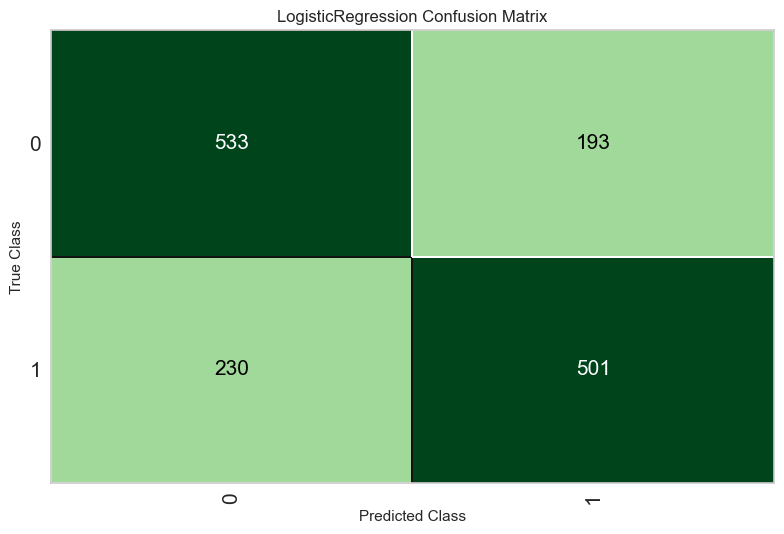

In [65]:
# plot confusion matrix
plot_model(tuned_model_tf, plot = 'confusion_matrix')

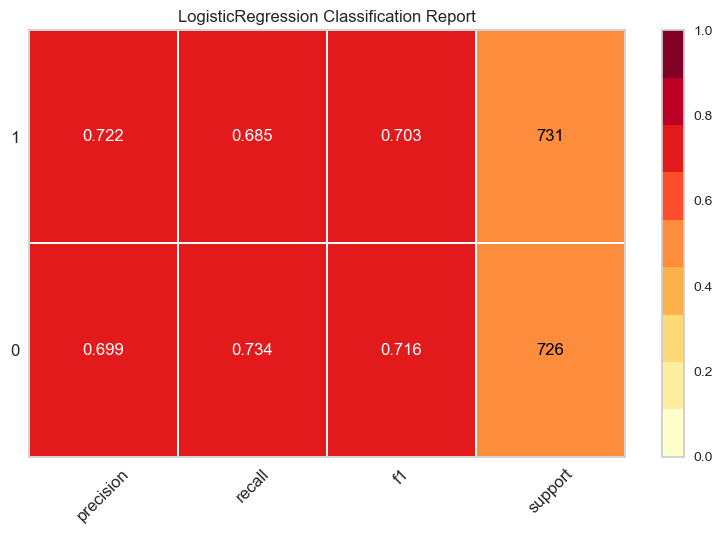

In [66]:
plot_model(tuned_model_tf, plot = 'class_report')

Dans cette représentation et ce modèle la classe 0 est mieux détectée que la classe 1.

In [67]:
pred_holdouts_tf = predict_model(tuned_model_tf)
pred_holdouts_tf.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7097,0.7838,0.6854,0.7219,0.7032,0.4194,0.4200


,0430,10,10 day,10 hour,10 min,10 minute,100,1000,1057,10pm,...,yucky,yum,yup,yup go,zac,zero,zone,target,prediction_label,prediction_score
3397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6564
3398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7215
3399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.7008
3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.7933
3401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5107


In [68]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model_tf)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['0430', '10', '10 day', '10 hour',
                                             '10 min', '10 minute', '100',
                                             '1000', '1057', '10pm', '11',
                                             '1130', '12', '12 hour', '12 week',
                                             '123', '1230', '13', '13 hour',
                                             '130', '14', '15', '15 hour',
                                             '15 min', '15 minute', '17', '18',
                                             '18 day', '186', '1am', ...],
                                    transformer=SimpleImputer(a...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 LogisticRegression(C=3.882, class_weight={}, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [69]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

# os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(tuned_model_tf, PATH + "models" + os.sep + "best_model_TFIdF_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0430', '10', '10 day', '10 hour',
                                              '10 min', '10 minute', '100',
                                              '1000', '1057', '10pm', '11',
                                              '1130', '12', '12 hour', '12 week',
                                              '123', '1230', '13', '13 hour',
                                              '130', '14', '15', '15 hour',
                                              '15 min', '15 minute', '17', '18',
                                              '18 day', '186', '1am', ...],
                                     transformer=SimpleImputer(a...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
        

In [70]:
# Générer des prédictions pour le jeu d'entrainement
predictions_tf = predict_model(tuned_model_tf, data=train_tfidf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9420,0.9861,0.9436,0.9409,0.9422,0.8840,0.8840


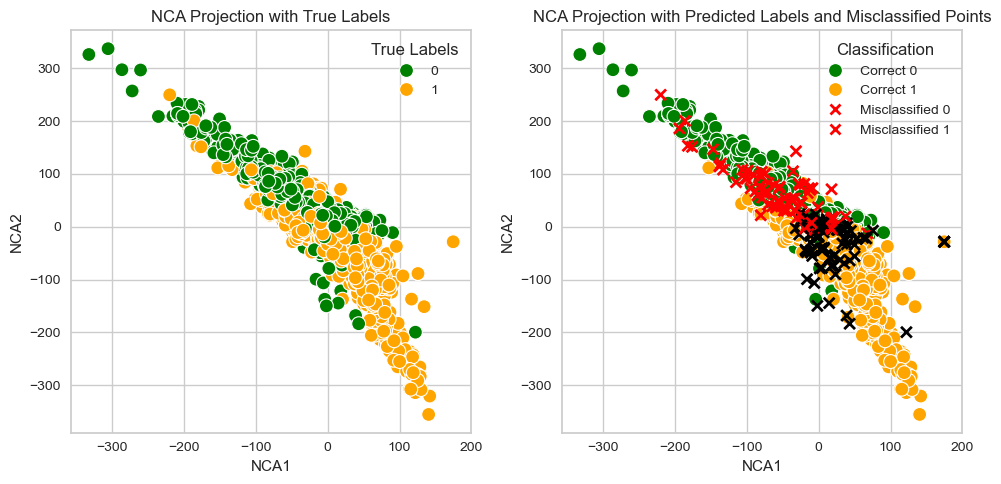


Faux Négatifs (Prédit comme 0, mais vrai label 1) :
- finally friday , but still grounded till next thursday    -- stereos = life &lt;333
- @cathybaron sounds like you caught it during the flight..  Get well soon! lots of honey &amp; lemon drinks!
- Had chilie con carne for dinner,just settled down to watch washington @ Yankees though its pissin in New York so there's a game delay 
- @northwesternsig good grief sig.  you must have a shit load of frequent flyer miles.  have fun! no mike rowe sucks 
- safe travels lady !! hope its not too freezing for you.. like .. seriously  @MissPhoenixxx Hope your flight goes well.. love you a ton Xx
- @RamsackDiego no  I won't but next sunday I will I need the old crew there. http://myloc.me/4Ksz
- @dannygokey Eek! That's too bad  Hope you have better luck with your luggage next time!
- @dannywood good morning danny..have a safe flight(short 1 i hope) &amp; yes im just now goin 2 bed..  @ what 445 gotta b up @ 745 LOVE YOU ~V~
- Going to the airport

In [76]:
df = predictions_tf
visualize_nca_predictions(df, train_df)